In [38]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

In [39]:
np.random.seed(10001)
sigma = 0.2
W = sigma * np.random.randn(100, 3)
np.savetxt('W.csv', W, delimiter=',')


np.random.seed(10001)
sigma = 0.5
u = sigma * np.random.randn(100)
np.savetxt('u.csv', u, delimiter=',')

In [40]:
A = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0.06, -0.47, 1.20]
])

B = np.array([0, 0, 1])[:, np.newaxis]

M = np.eye(3)
R = 0.1

T = 100

x0 = np.zeros((3,))[:, np.newaxis]
ut = 0  # zero policy

In [41]:
W = np.genfromtxt("W.csv", delimiter=",")
W.shape

(100, 3)

In [42]:
print(np.round(W[0, 0], 4))
print(np.round(W[1, 1], 4))
print(np.round(W[2, 2], 4))

-0.0411
0.1229
-0.2518


In [43]:
def calc_phi(xt, ut):
    m = len(xt)
    
    if type(ut) in [int, float]:
        n = 1
    else:
        n = len(ut)
    poly_arr = np.ones((m*2+2, n))  # axis 0 is poly, axis 1 is different u values
    for i in range(m):
        poly_arr[2*i+1, :] = (xt[i])**2
        poly_arr[2*i+2, :] = xt[i]*ut
    poly_arr[-1, :] = ut**2
    return poly_arr

def transition(xt, ut, wt):
    xt1 = A @ xt + B * ut + wt
    return xt1

def cost(xt, ut):
    return xt.T @ M @ xt + R * ut**2

def calc_ut(xt, K):
    return -K @ xt

def run_simulation(x0, u_arr, w_arr, iter_lim=None):
    assert u_arr.shape[0] == w_arr.shape[0]
    x_arr = []
    C_arr = []
    x = copy.deepcopy(x0)
    iter_count = 0
    for i, u in enumerate(u_arr):
        w = w_arr[i%100, :][:, np.newaxis]
        # print("w.shape =", w.shape)
        x = transition(x, u, w)
        C = cost(x, u)
        
        x_arr.append(x)
        C_arr.append(C)
        
        if iter_lim is not None:
            iter_count += 1
            if iter_count > iter_lim:
                break
    
    x_arr = np.array(x_arr).squeeze()
    C_arr = np.array(C_arr).squeeze()
    # print(C_arr.shape)
    J_arr = C_arr.cumsum()
    
    return x_arr, C_arr, J_arr

def calc_Q(xt, ut, theta):
    phi = calc_phi(xt, ut)
    return theta.T @ phi

def run_Q_simulation(x0, w_arr, theta0, T=100, alpha=None, epsilon=None):
    x_arr = [x0]
    u_arr = []
    C_arr = []
    theta_arr = [theta0]
    
    x = copy.deepcopy(x0)
    theta = copy.deepcopy(theta0)

    for i in range(T):
        w = w_arr[i%100, :][:, np.newaxis]

        u = -1/(2*theta[-1]) * (theta[2]*x[0] + theta[4]*x[1] + theta[6]*x[2])
        u_arr.append(u)

        Q = calc_Q(x, u, theta)
        
        x = transition(x, u, w)
        C = cost(x, u)
        x_arr.append(x)
        C_arr.append(C)

        new_u = -1/(2*theta[-1]) * (theta[2]*x[0] + theta[4]*x[1] + theta[6]*x[2])

        if alpha is not None:  # if there is a learning rate, update theta
            theta = theta + alpha * calc_phi(x, u) * (C + calc_Q(x, new_u, theta) - Q)
            theta_arr.append(theta)
        
    u_arr = np.array(u_arr).squeeze()
    x_arr = np.array(x_arr).squeeze()
    C_arr = np.array(C_arr).squeeze()
    theta_arr = np.array(theta_arr).squeeze()
    
    J_arr = C_arr.cumsum()
    # print("Cumulative cost:", J_arr[-2])
    return x_arr, C_arr, J_arr, theta_arr

In [44]:
from scipy import linalg as la
P = la.solve_discrete_are(A, B, M, R)
K = la.solve(R + B.T.dot(P).dot(B), B.T.dot(P).dot(A))
K

array([[ 0.0582, -0.4535,  1.1459]])

In [45]:
T = 100
x = x0
x_arr = [x0]
u_arr = []
for t in range(T):
    u = calc_ut(x, K)
    w = W[t, :][:, np.newaxis]
    u_arr.append(u)
    x = transition(x, u, w)
u_arr = np.array(u_arr)

In [46]:
performance_dict = {}

# LQR
performance_dict["LQR"] = run_simulation(x0, u_arr, W)

# Zero policy
u_arr = np.zeros(T)
performance_dict["Zero"] = run_simulation(x0, u_arr, W)

# Random policy
u_arr = np.genfromtxt("u.csv", delimiter=",")
performance_dict["Random"] = run_simulation(x0, u_arr, W)

In [47]:
theta0 = np.array([1, 1, 1, -2, -2, 2, 2, 1])[:, np.newaxis]

x_arr_naive, C_arr, J_arr, theta_arr = run_Q_simulation(x0, W, theta0, T=100)
print(theta_arr.squeeze().shape)

(8,)


In [48]:
theta0 = np.array([1, 1, 1, -2, -2, 2, 2, 1])[:, np.newaxis]

x_arr, C_arr, J_arr, theta_arr = run_Q_simulation(x0, W, theta0, T=100*5, alpha=0.01)
theta_arr[0, :][:, np.newaxis].shape

(8, 1)

38.985339935128735


(20.0, 90.0)

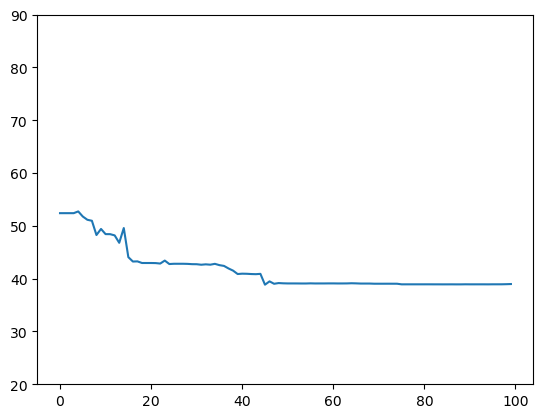

In [49]:
cum_cost_arr = []
for t in range(100):
    theta = theta_arr[t, :][:, np.newaxis]
    x_arr_QL, J_arr = run_Q_simulation(x0, W, theta)[0:3:2]
    cum_cost_arr.append(J_arr[-2])

print(cum_cost_arr[-1])

plt.plot(cum_cost_arr)
plt.ylim((20, 90))

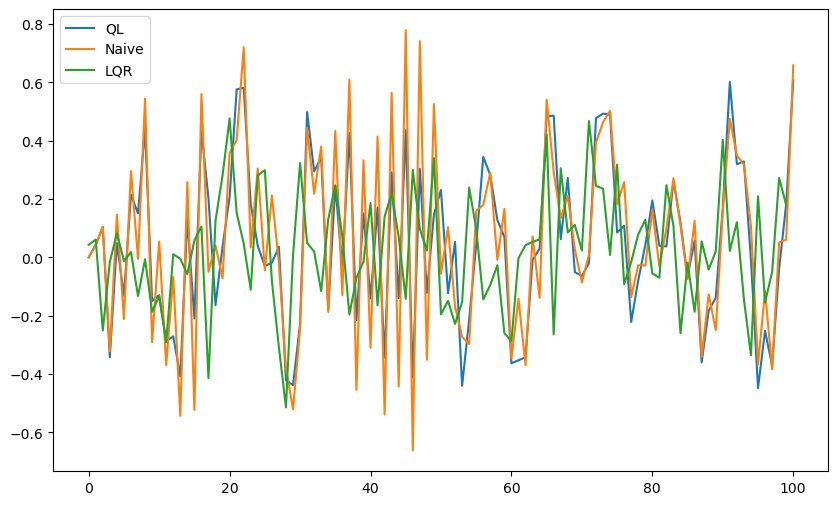

In [50]:
x_arr_LQR = performance_dict["LQR"][0]

plt.figure(figsize=(10, 6))
plt.plot(x_arr_QL[:, -1], label="QL")
plt.plot(x_arr_naive[:, -1], label="Naive")
plt.plot(x_arr_LQR[:, -1], label="LQR")
plt.legend()